# COMP3359 Project
## Group 28: Classification of Tropical Cyclone Satellite Image by Intensity

---

### Introduction
In this project, we intend to develop a CNN-based model that accepts a satellite image of a tropical cyclone (TC) as input and predicts a label, an intensity class, for it. We intend to let an AI model perform it without knowing the exact rules and features to look for. There are six classes, namely class 0, class 1, class 2 a tropical depression, class 3 tropical storm, class 4 severe tropical storm and class 5 typhoon/hurricane (depending on in which part of the world do you live).

The dataset used is obtained from the National Institute of Informatics (Japan), provided by Prof. A. Kitamoto of to whom we are highly indebted for his kind permission to use his data.

This notebook will be the implementation of our methodology, which is essentially a CNN multi-class image classifier.

References used:
- Dvorak, V.F. (1975, 5) Tropical Cyclone Intensity Analysis and Forecasting From
Satellite Imagery. Monthly Weather Review , Volume 3, pp.420-430.
- Dvorak, V.F. (1984) Tropical Cyclone Intensity Analysis Using Satellite Data. National
Oceanic and Atmospheric Administration. Washington D.C.: National Oceanic and
Atmospheric Administration.

Code referenced
- Pytorch, Imagenet Example
https://github.com/pytorch/examples/blob/master/imagenet/main.py

### Table of Content

---
- Preperation and Prerequisites
- Data Exploration and Preprocesssing
- Protoptyping models 
    - Model 1: DenseNet
    - Model 2: EfficientNetb0
    - Model 3: CustomNet
- Final model - EfficientNetb3
- Training
- Trained model analysis 



### Preperation and Prerequesites

> This notebook designs to run un HKU GPU Farm, running it in colab will not work.  
> Also, this notebook designs for GPU only, it can't run with only CPU.

#### About data format
The raw data obtained (details below) were transformed into HDF5 format. This is due to the limited disk size in both colab and HKU gpu farm, which made us unable to load all pickle files (the original format) to VM's disk. Accessing them from google drive also super slow and unstable. Therefore, we merge them into once single HDF5 file with compression, which is 20% of orginial size. Also, HDF5 supports concurrent read which further speed up loading speed. The image data was originally float32, but we compressed it to uint8, which is also due to the disk limitation and we also found there is no big different in terms of quality.

In [22]:
""" Install correct pytorch version """
# Uncomment % ... to see your CUDA version
# !/usr/local/cuda/bin/nvcc --version

# If you are using CUDA 10.0 (HKU GPU Phrase 1)
# !pip install Pillow==6.1
# !pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.1
# !pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# If you have CUDA 10.2
# !pip install pytorch torchvision

' Install correct pytorch version '

In [23]:
""" Python packages you might need """
# !pip install h5py opencv-python
# !pip install efficientnet-pytorch
# !pip install torchsummary 

' Python packages you might need '

In [24]:
""" Import packages """
import glob
import os
import sys

import h5py
import numpy as np
import pandas as pd
import torch

In [25]:
""" Set path to data: """
# We dumped everything at root, so yeah.
dataset_dir = '.'
sys.path.append(dataset_dir)
IMAGES_H5 = f'{dataset_dir}/compressed_images.hdf5'
NPY_FOLDER = f'{dataset_dir}/uint8'

In [26]:
# Know more about your machine
print(torch.cuda.get_device_name() if torch.cuda.is_available() else "No GPU")
print(os.cpu_count())

GeForce GTX 1080 Ti
8


In [27]:
# Load attribute of images from csv
LABELS = pd.read_csv(f"{dataset_dir}/labels_with_images.csv")
len(LABELS)

163665

In [28]:
# Alternatively you can load a particular image directly from disk (Slow)
# Helper function to get a image array from HDF5 file
def getImageFromH5(h5, row):
    img_name = f"{row['sequence']}{row['raw_index']}"
    return h5[img_name][()]

In [29]:
# Alternative 2: Load it in from npy format(Faster in theory)
def getImageFromNPY(row):
    img_name = f"{row['sequence']}{row['raw_index']}"
    return np.load(f"{NPY_FOLDER}/{img_name}.npy")

## Data Exploration and Preprocessing

As mentioned in the proposal, we would use the dataset by Prof. A. Kitamoto of the National Institute of Informatics (NII). Via his website “Digital Typhoon”, a platform that provides historical data (including satellite images) of tropical cyclones, we have successfully obtained his research dataset for the use of this project. On Thursday 23 April, the magical day finally came, as we first laid hands on the dataset.

The dataset we obtained is immense. Compressed, the dataset is 43GB in size, which includes utility and sample code for our use, alongside with the main dish: **164541** images from 1978 to 2019, initially organized as pickles files (grouped by year), with the following columns:

* date and time when the image was taken
* class: intensity class as categroized by NII
* latitude and longitude of the TC in the image
* pressure (hectopascals/hPa): raw information of the TC's intensity
* interpolated: whether all data above were calculated by interpolation
* image: a multi-dimensional array that contains the image data. Each pixel on the image encodes temperature (in Kelvin).

> Some of these fields are usused and would be dropped in due course.

#### Our preprocessing workflow  
 1. Drop labels that do not have images  
 2. Compressing original floating point images into integer  
 3. Export it to npy format or hdf5 format if storage is limited  

The following code reads the data and produces some plot about the distribution of the data. Similar procedures have been done for the interim model.

### Exploring the data 


In [30]:
# Lets go with import as usual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [31]:
# Append year to Label dataset for later use
LABELS = LABELS[['sequence', 'raw_index', 'datetime',
                 'class', 'latitude', 'longitude', 'pressure', 'TCxETC']]
LABELS['year'] = pd.to_datetime(
    LABELS['datetime'], format='%Y-%m-%d %X').dt.year
LABELS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163665 entries, 0 to 163664
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sequence   163665 non-null  int64  
 1   raw_index  163665 non-null  int64  
 2   datetime   163665 non-null  object 
 3   class      163665 non-null  int64  
 4   latitude   163665 non-null  float64
 5   longitude  163665 non-null  float64
 6   pressure   163665 non-null  float64
 7   TCxETC     163665 non-null  int64  
 8   year       163665 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 11.2+ MB


Sample data:


<Figure size 720x720 with 0 Axes>

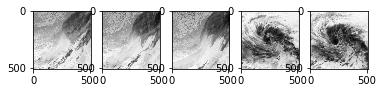

In [34]:
# Let's look at some sample images
plt.figure(figsize=(10, 10))
print("Sample data:")
fig, ax = plt.subplots(1, 5)
with h5py.File(IMAGES_H5, 'r') as h5:
    for i in range(5):
        img = getImageFromH5(h5, LABELS.loc[i])
        ax[i].imshow(img, cmap='gray')
plt.show()

Sample data:


<Figure size 720x720 with 0 Axes>

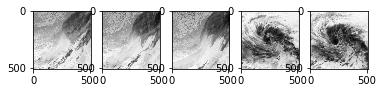

In [35]:
# If you using npy folder instead of hdf5
plt.figure(figsize=(10, 10))
print("Sample data:")
fig, ax = plt.subplots(1, 5)
for i in range(5):
    img = getImageFromNPY(LABELS.loc[i])
    ax[i].imshow(img, cmap='gray')
plt.show()

In [36]:
sequence = LABELS['sequence'].values
raw_index = LABELS['raw_index'].values

In [37]:
# Labels of each row
list(LABELS.columns.values)

['sequence',
 'raw_index',
 'datetime',
 'class',
 'latitude',
 'longitude',
 'pressure',
 'TCxETC',
 'year']

Classes: [0 1 2 3 4 5]
Distribution 
0    42312
3    40694
1    36358
2    25703
4    18447
5      151
Name: class, dtype: int64


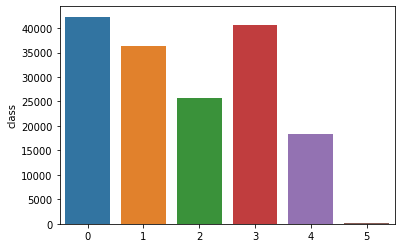

In [38]:
# Class distribution
classes = np.sort(LABELS['class'].unique())
print("Classes:", classes)
print("Distribution ")
dist = LABELS['class'].value_counts()
print(dist)
sns.barplot(dist.index, dist)

In [39]:
# Code studies the relationship between classes and pressure value
pressure = LABELS['pressure']
for x in range(6):
    range_min = 2000.0
    range_max = 0.0
    for _, row in LABELS.iterrows():
        if row['class'] == x:
            if row['pressure'] > range_max:
                range_max = row['pressure']
            elif row['pressure'] < range_min:
                range_min = row['pressure']
    print("Class ", x, " pressure range = {} - {}".format(range_min, range_max))

Class  0  pressure range = 982.0 - 1018.0
Class  1  pressure range = 969.5 - 1011.333333
Class  2  pressure range = 951.666667 - 1005.0
Class  3  pressure range = 870.0 - 995.0
Class  4  pressure range = 940.0 - 1018.0
Class  5  pressure range = 925.0 - 1018.0


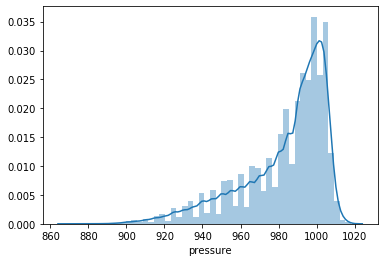

In [40]:
# Pressure distribution
pressure = LABELS['pressure']
sns.distplot(pressure)

In [41]:
# Pressure decile
decile = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
cutoff = pressure.quantile(decile)
print("Median of each quantile")
print(cutoff)
qcutted = pd.qcut(pressure, 10, labels=False)
print("Number of image in each bin")
qcutted.value_counts().sort_index()

Median of each quantile
0.1     950.000000
0.2     965.000000
0.3     977.000000
0.4     985.000000
0.5     990.666667
0.6     995.000000
0.7     998.000000
0.8    1002.000000
0.9    1004.000000
Name: pressure, dtype: float64
Number of image in each bin


0    18833
1    14951
2    15325
3    19252
4    13710
5    16662
6    16263
7    20964
8    12134
9    15571
Name: pressure, dtype: int64

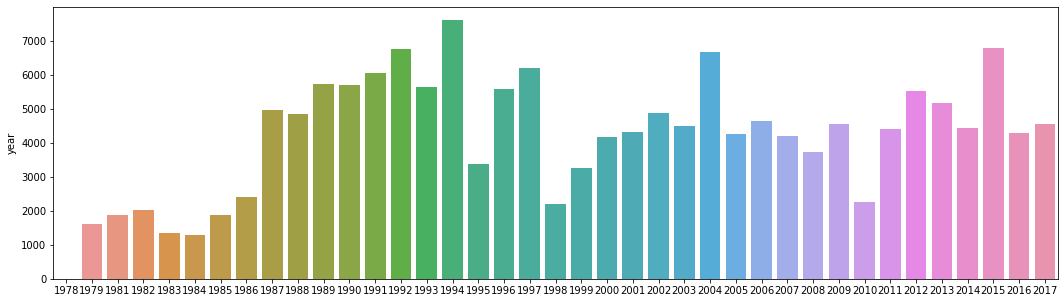

In [53]:
# By Year
years = LABELS['year']
count_years = years.value_counts()
plt.figure(figsize=(18, 5))
sns.barplot(count_years.index, count_years)

#### Observations
There are some observations we made about the dataset.

* There is a general lack of images of stronger TCs.
  * Based on the given classes (0-5), we can observe that the classes 4 and 5 have much fewer samples than other classes.
  * While class 6 TCs are extremely spared.  
  * It is beyond doubt that this is because stronger TCs do not happen as frequently.
  * We would bear with it for now and observe what is going to happen.
  * Potential solutions are:
    * Rotate some images to make up for the numbers, but the images would be similar
    * Check other sources for images, but the images would have different dimensions/zooming levels or may require other preprocessing
    * Drop them because it may become noise and affect the model accuracy on other class

### Preprocessing for training model

This part is rather straightforward. 

1. Selected the label attributes of interest.
2. Separate dataset into train, dev and test sets. 
3. Pack them into PyTorch dataLoader pipeline by the time we start training (the code is at the bottom), this step is reserved for later because pre-trained and custom models have different pre-processing requirements.
4. Randomly resize, crop and flip the images to introduce randomness and cull overfitting
5. Normalize images, so that all values in each images are between 0 to 1
6. Convert images to train-ready tensors

In [54]:
# Import 
from sklearn.model_selection import train_test_split

In [55]:
# Pick useful label attributes only
processed_labels = LABELS[['class','sequence','raw_index','year']]

In [56]:
""" Group data into Train, Dev, Test set """
# To prevent data leak, we seperate test data by year


def prepare_dataset(labels, ratio, year):
    processed_labels = labels[['class', 'sequence', 'raw_index', 'year']]
    test_set = processed_labels[processed_labels['year'] >= year]
    traindev_set = processed_labels[processed_labels['year'] < year]
    train_set, dev_set = train_test_split(
        traindev_set, train_size=ratio)
    print("[Test Size {}] [Train Size {}] [Dev Size {}]".format(
        len(test_set), len(train_set), len(dev_set)))
    return {'train': train_set, 'dev': dev_set, 'test': test_set}


_ = prepare_dataset(LABELS, 0.8, 2012)

[Test Size 30738] [Train Size 106341] [Dev Size 26586]


In [57]:
# Import pytorch and packages gonna use
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchsummary import summary

In [58]:
""" Custom PyTorch Dataset """


class TyDataset(Dataset):
    def __init__(self, df, transform, channel=1):
        self.df = df
        self.transform = transform
        self.channel = channel
        self.sequence = df['sequence'].values
        self.raw_index = df['raw_index'].values

    def __len__(self):
        return len(self.df)

    def getImg(self, idx):
        # If you are using npy
        return np.load(f"{NPY_FOLDER}/{self.sequence[idx]}{self.raw_index[idx]}.npy")
        # If you are using hdf5
        # with h5py.File(f"{dataset_dir}/compressed_images.hdf5", 'r') as h5:
        #     return getImageFromH5(h5, self.df.iloc[idx])

    # When use against with DenseNet you need to make img_arr to have 3 channels, to do so
    # either by PIL convert('RGB') or use numpy stack(, axis=-1)
    def __getitem__(self, idx):
        img_arr = self.getImg(idx)
        if self.channel == 3:
            img = Image.fromarray(np.stack((img_arr,)*3, axis=-1))
        else:
            img = Image.fromarray(img_arr)
        image = self.transform(img)
        label = self.df.iloc[idx]['class']
        return image, label

Raw -> Stacked -> Transformed


<Figure size 720x720 with 0 Axes>

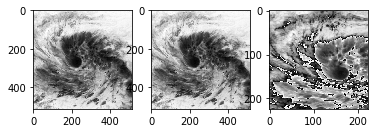

In [59]:
# Transformation we going to use
# Here is just the demo of transformation, the real transformation will defined right before main training loop for easier editing
plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(1, 3)

transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# img = getImageFromNPY(LABELS.loc[i])
with h5py.File(f"{dataset_dir}/compressed_images.hdf5", 'r') as h5:
    getImageFromH5(h5, LABELS.iloc[i])
ax[0].imshow(img, cmap='gray')
# Pretrained CNN network usually need input to have 3 channels, here we stack our array 3 times to pretend we have it
stacked_img = Image.fromarray(np.stack((img,)*3, axis=-1))
ax[1].imshow(stacked_img, cmap='gray')
transformed_img = transform(stacked_img)
ax[2].imshow(transforms.ToPILImage()(transformed_img), cmap='gray')
print("Raw -> Stacked -> Transformed")
plt.show()

## Models

### Densenet161 [Prototyping]

Firstly we try to use a pre-trained CNN "densenet161" and see how it performs with our data. It was a state of art network which is widely used in images classification. Here we use it to extract features and then pass them into a simple fully connected network classifier.

For loss function we chose cross entropy loss and optimizer is Adam, because they generally work in every problem which is good for prototyping.

In [80]:
""" Densenet161 + fully connected classifier Model """
import torchvision.models as models


class Dense161Net(nn.Module):
    def __init__(self):
        super(Dense161Net, self).__init__()
        self.conv = self.densenet()
        self.fc = nn.Sequential(
            # 1000 is the default output size in densenet161
            nn.Linear(1000, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 6)
        )

    def densenet(self):
        # Load pretrained paramas to speed up training
        model = models.densenet161(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False
        return model

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x
    
summary(Dense161Net().cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 112, 112]          14,112
       BatchNorm2d-2         [-1, 96, 112, 112]             192
              ReLU-3         [-1, 96, 112, 112]               0
         MaxPool2d-4           [-1, 96, 56, 56]               0
       BatchNorm2d-5           [-1, 96, 56, 56]             192
              ReLU-6           [-1, 96, 56, 56]               0
            Conv2d-7          [-1, 192, 56, 56]          18,432
       BatchNorm2d-8          [-1, 192, 56, 56]             384
              ReLU-9          [-1, 192, 56, 56]               0
           Conv2d-10           [-1, 48, 56, 56]          82,944
      BatchNorm2d-11          [-1, 144, 56, 56]             288
             ReLU-12          [-1, 144, 56, 56]               0
           Conv2d-13          [-1, 192, 56, 56]          27,648
      BatchNorm2d-14          [-1, 192,

### EfficientNet-b0 [Prototyping]

We also tested another state of the art CNN model, EfficientNet. Similar to DenseNet approach, we use it to extract features and the use a fully connected network for classification

In [83]:
# We also want to test another state of art cnn model, EfficientNet
from efficientnet_pytorch import EfficientNet


class Effb0Net(nn.Module):
    def __init__(self):
        super(Effb0Net, self).__init__()

        self.conv = EfficientNet.from_pretrained('efficientnet-b0')

        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(1280, 6)
        )

    def forward(self, x):
        x = self.conv.extract_features(x)
        x = self.fc(x)
        return x

summary(Effb0Net().cuda(), (3, 224, 224))

Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13        

### DIY CNN model [Prototyping]

Last but not least, we also tired to design a CNN network by ourselves. Given the high complexity of a satellite image, we believes that a deep network may be suitable for it. Therefore, we try to use large number of channels and convolution layers to increase the number of feature maps. 

In [84]:
""" Custom CNN Model """


class CustomNet1(nn.Module):
    def __init__(self):
        super(CustomNet1, self).__init__()
        # CNN Model layers
        # Input shape: Batch size B, 1 channel, 512, 512

        # conv. layers
        self.conv = nn.Sequential(
            # After 1st conv: (B, 1, 512, 512) -> (B, 16, 512, 512)
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
            # After AvgPool2d: (B, 16, 512, 512) -> (B, 16, 128, 128)
            nn.AvgPool2d(kernel_size=4),
            # After 2nd conv: (B, 16, 128, 128) -> (B, 32, 128, 128)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            # After AvgPool2d: (B, 32, 128, 128) -> (B, 32, 32, 32)
            nn.AvgPool2d(kernel_size=4),
            # After 3rd conv: (B, 32, 32, 32) -> (B, 64, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            # After AvgPool2d: (B, 64, 32, 32) -> (B, 64, 16, 16)
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            # After AvgPool2d: (B, 128, 32, 32) -> (B, 128, 8, 8)
            nn.AvgPool2d(kernel_size=2),
            nn.Flatten()
        )

        # FC layers
        self.fc = nn.Sequential(
            nn.Linear(128*8*8, 1024),
            nn.ReLU(True),
            nn.Dropout(0.20),
            nn.Linear(1024, 128),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

summary(CustomNet1().cuda(), (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             144
         AvgPool2d-2         [-1, 16, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           4,640
              ReLU-4         [-1, 32, 128, 128]               0
         AvgPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
         AvgPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
             ReLU-10          [-1, 128, 16, 16]               0
        AvgPool2d-11            [-1, 128, 8, 8]               0
          Flatten-12                 [-1, 8192]               0
           Linear-13                 [-1, 1024]       8,389,632
             ReLU-14                 [-

## Final Model
### EfficientNet-b3
In our final network, we decided to further increase the depth and width of our network. First, we switched to a larger efficientnet, 'efficientnet-b3', because a larger net can extract more features which should increase the accuracy. Second, we expanded the depth of the fully connected classifier to combat overfit and also introduce more nonlinear function to allow the model learn better.

In [85]:
class EffNet(nn.Module):
    # Of course you need to check you are training the correct model or not
    def __init__(self):
        super(EffNet, self).__init__()

        self.conv = EfficientNet.from_pretrained('efficientnet-b3')
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(1536, 768),
            nn.Dropout(0.35),
            nn.ELU(inplace=True),
            nn.Linear(768, 6)
        )

    def forward(self, x):
        x = self.conv.extract_features(x)
        x = self.fc(x)
        return x

summary(EffNet().cuda(), (3, 224, 224))

Loaded pretrained weights for efficientnet-b3
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 40, 112, 112]           1,080
       BatchNorm2d-3         [-1, 40, 112, 112]              80
MemoryEfficientSwish-4         [-1, 40, 112, 112]               0
         ZeroPad2d-5         [-1, 40, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 40, 112, 112]             360
       BatchNorm2d-7         [-1, 40, 112, 112]              80
MemoryEfficientSwish-8         [-1, 40, 112, 112]               0
          Identity-9             [-1, 40, 1, 1]               0
Conv2dStaticSamePadding-10             [-1, 10, 1, 1]             410
MemoryEfficientSwish-11             [-1, 10, 1, 1]               0
         Identity-12             [-1, 10, 1, 1]               0
Conv2dStaticSamePadding-13        

## Train, Vaildate, Test: All Training Procedures

### Training Utility Functions

In [64]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


In [65]:
class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [66]:
def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 every 25 epochs"""
    lr = lr * (0.1 ** (epoch // 25))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [67]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [68]:
def accuracy(output, target):
    """Computes the accuracy over the top predictions"""
    with torch.no_grad():
        batch_size = target.size(0)
        
        _, preds = torch.max(output.data, 1)
        correct = (preds == target).sum().item()

        return correct/batch_size

### Main Training Functions

In [69]:
def train(train_loader, model, criterion, optimizer, epoch, freq, gpu):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, data_time, losses, top1,
                             prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        input = input.cuda(gpu, non_blocking=True)
        target = target.cuda(gpu, non_blocking=True)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1 = accuracy(output, target)
        losses.update(loss.item(), input.size(0))
        top1.update(acc1, input.size(0))

        # compute gradient and run optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % freq == 0:
            progress.print(i)

    return top1.avg, losses.avg

In [70]:
def validate(val_loader, model, criterion, freq, gpu):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time,
                             losses, top1, prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1 = accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            top1.update(acc1, input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % freq == 0:
                progress.print(i)

        print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg, losses.avg


In [71]:
import time

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

In [72]:
def main_worker(gpu, args):
    global best_acc1

    print("Worker {} starts".format(gpu))

    best_acc1 = 0
    ddl = args['ddl']
    lr = args['lr']
    freq = args['freq']

    if ddl:
        dist.init_process_group(
            backend='nccl',
            world_size=args['world_size'],
            rank=gpu
        )

    # define model
    torch.cuda.set_device(gpu)
    model = args['model']
    model.cuda(gpu)

    if ddl:
        args['batch_size'] = int(args['batch_size']/args['gpus'])
        args['worker_size'] = int(
            (args['worker_size'] + args['gpus'] - 1) / args['gpus'])
        model = DDP(model, device_ids=[gpu])

    # define loss function (criterion) and optimizer
    criterion = nn.CrossEntropyLoss().cuda(gpu)

    optimizer = torch.optim.Adam(model.parameters(), lr)

    torch.backends.cudnn.benchmark = True

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        args['train_set']) if ddl else None

    train_loader = DataLoader(args['train_set'],
                              batch_size=args['batch_size'],
                              num_workers=args['worker_size'],
                              pin_memory=args['pin_memory'],
                              drop_last=True,
                              shuffle=(ddl is False),
                              sampler=train_sampler)

    dev_loader = DataLoader(args['dev_set'],
                            batch_size=args['batch_size'],
                            num_workers=args['worker_size'],
                            pin_memory=args['pin_memory'],
                            drop_last=True,
                            shuffle=False)

    train_losses = []
    train_accs = []
    dev_losses = []
    dev_accs = []

    for epoch in range(0, args['epochs']):
        if ddl:
            train_sampler.set_epoch(epoch)

        adjust_learning_rate(optimizer, epoch, lr)

        # train for one epoch
        acc1, loss = train(train_loader, model, criterion,
                           optimizer, epoch, freq, gpu)
        train_accs.append(acc1)
        train_losses.append(loss)

        # evaluate on validation set
        acc1, loss = validate(dev_loader, model, criterion, freq, gpu)
        dev_accs.append(acc1)
        dev_losses.append(loss)

        # remember best acc@1 and save checkpoint
        is_best = acc1 > best_acc1
        best_acc1 = max(acc1, best_acc1)

        if not ddl or (ddl and gpu == 0):
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'best_acc1': best_acc1,
                'optimizer': optimizer.state_dict(),
            }, is_best)

    # Save stat for analysis usage
    print('Train Loss over epoch :', train_losses)
    print('Train Acc over epoch :', train_accs)
    print('Dev Loss over epoch :', dev_losses)
    print('Dev Acc over epoch :', dev_accs)
    data = {'Train_Loss': train_losses, 'Train_Accuracy': train_accs,
            'Dev_Loss': dev_losses, 'Dev_Accuracy': dev_accs}
    pd.DataFrame(data=data).to_csv(f'{dataset_dir}/train_stats-{gpu}.csv')


In [73]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

dev_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])


In [74]:
""" 
Multi GPU will only work in python script(.py), trying to do so in notebook 
will cause inf hang.
"""


def main():
  # Define arguments here
    args = {
        'model': EffNet(),
        'epochs': 50,
        'lr': 0.01,
        'freq': 100,
        'batch_size': 64,
        'worker_size': 8,
        'pin_memory': True,
        'ddl': False
    }

    dataset = prepare_dataset(LABELS, 0.8, 2012)
    args['train_set'] = TyDataset(dataset['train'], train_transform, channel=3)
    args['dev_set'] = TyDataset(dataset['dev'], dev_transform, channel=3)

    if torch.cuda.device_count() > 1:
        args['gpus'] = torch.cuda.device_count()
        print("Distribute work to {} GPU".format(args['gpus']))
        # Planning to use 1 node + multi-GPU only, so world size = GPU count * 1
        args['world_size'] = args['gpus']
        args['ddl'] = True
        # Set up Master node listening port/addr
        os.environ['MASTER_ADDR'] = 'localhost'
        os.environ['MASTER_PORT'] = '8889'
        # Spawn processes according to world_size
        mp.spawn(main_worker, nprocs=args['gpus'], args=(args,))
    else:
        main_worker(0, args)


In [ ]:
# Uncomment to run main training loop 
# main()

## Trained Model Analysis

This part will generate data and graph that is useful for our analysis

In [75]:
# Confusion Matrix


def validate_with_all_preds(val_loader, model, criterion, freq, gpu):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time,
                             losses, top1, prefix='Test: ')

    all_preds = []
    all_labels = []

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input = input.cuda(gpu, non_blocking=True)
            target = target.cuda(gpu, non_blocking=True)

            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc1 = accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            top1.update(acc1, input.size(0))

            # Saves all preds and their corresponding ground truth
            preds = torch.argmax(output.data, 1)
            all_preds.extend(preds)
            all_labels.extend(target)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % freq == 0:
                progress.print(i)

        print(' * Acc@1 {top1.avg:.3f}'.format(top1=top1))

    return {'acc': top1.avg,
            'loss': losses.avg,
            'predictions': all_preds,
            'labels': all_labels}


In [86]:
""" Evaluating with test set and a saved model """
model = EffNet()
temp = torch.load('./effnet3/model_best.pth.tar')
model.load_state_dict(temp['state_dict'])
model = model.cuda()

Loaded pretrained weights for efficientnet-b3


In [77]:
dataset = prepare_dataset(LABELS, 0.8, 2012)
test_ds = TyDataset(dataset['test'], test_transform, channel=3)

test_loader = DataLoader(test_ds,
                         batch_size=32,
                         num_workers=8,
                         pin_memory=True,
                         drop_last=True,
                         shuffle=True)

test_result = validate_with_all_preds(val_loader=test_loader, model=model,
                                      criterion=nn.CrossEntropyLoss().cuda(0),
                                      freq=100, gpu=0)
print(f"Acc: {test_result['acc']} Loss: {test_result['loss']}")


[Test Size 30738] [Train Size 106341] [Dev Size 26586]
Test: [  0/960]	Time  5.218 ( 5.218)	Loss 6.6033e-01 (6.6033e-01)	Acc@1   0.69 (  0.69)
Test: [100/960]	Time  0.814 ( 0.860)	Loss 5.5437e-01 (8.2356e-01)	Acc@1   0.78 (  0.69)
Test: [200/960]	Time  0.815 ( 0.838)	Loss 8.8593e-01 (8.4163e-01)	Acc@1   0.69 (  0.69)
Test: [300/960]	Time  0.814 ( 0.831)	Loss 2.5120e-01 (8.3084e-01)	Acc@1   0.91 (  0.69)
Test: [400/960]	Time  0.814 ( 0.827)	Loss 1.0134e+00 (8.2992e-01)	Acc@1   0.69 (  0.70)
Test: [500/960]	Time  0.815 ( 0.825)	Loss 9.4555e-01 (8.3110e-01)	Acc@1   0.69 (  0.70)
Test: [600/960]	Time  0.814 ( 0.823)	Loss 5.9849e-01 (8.3100e-01)	Acc@1   0.78 (  0.70)
Test: [700/960]	Time  0.814 ( 0.823)	Loss 1.0451e+00 (8.3236e-01)	Acc@1   0.69 (  0.70)
Test: [800/960]	Time  0.819 ( 0.822)	Loss 9.6670e-01 (8.3005e-01)	Acc@1   0.56 (  0.70)
Test: [900/960]	Time  0.814 ( 0.821)	Loss 1.1584e+00 (8.2884e-01)	Acc@1   0.62 (  0.70)
 * Acc@1 0.700
Acc: 0.699609375 Loss: 0.8278335133257012


Shapes: torch.Size([30720]) ; torch.Size([30720])


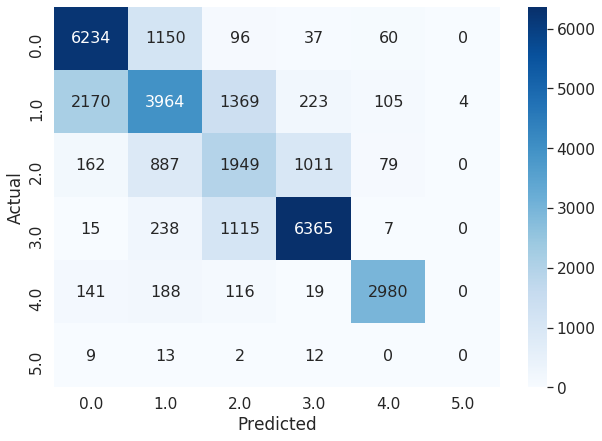

In [78]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

train_preds, train_truth = torch.FloatTensor(
    test_result['predictions']), torch.FloatTensor(test_result['labels'])

print("Shapes:", train_preds.size(), ";", train_truth.size())

data = confusion_matrix(train_truth, train_preds)
df_cm = pd.DataFrame(data, columns=np.unique(
    train_truth), index=np.unique(train_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize=(10, 7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='d')